# Artwork Created by Neural Style Transfer

Algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576)

In [2]:
#Import libraries
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

Neural Style Transfer (NST) merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S. 

A previously trained convolutional network (VGG-19) is used for the task. It has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers).

In [2]:
#Loading the model
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

The ultimate aim is to lower both the "content cost" and the "style cost"

In [2]:
# Content cost = the different between the activation of the content image and generated image at a certain layer
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(tf.transpose(a_C),[n_C,n_H*n_W])
    a_G_unrolled = tf.reshape(tf.transpose(a_G),[n_C,n_H*n_W])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1/(4*n_H*n_W*n_C)) *tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))
    
    return J_content

In [3]:
# Style cost involved the calculation of gram matrix, the correlation between the activation of channels at every point
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [4]:
# Style cost = different between the gram matrix of the style image and generated image
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S),[n_C,n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G),[n_C,n_H*n_W])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1/(4*np.square(n_H*n_W)*np.square(n_C))) *tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
    
    
    return J_style_layer

In [5]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [6]:
# Compute style cost of multiple layers - this is more useful than just using a single layer

def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [7]:
# Total cost = content cost + style cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha*J_content + beta*J_style
    
    return J

Now start the workflow after finish defining necessary functions.

In [21]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

/Users/ayim/Desktop/virenv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


/Users/ayim/Desktop/virenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


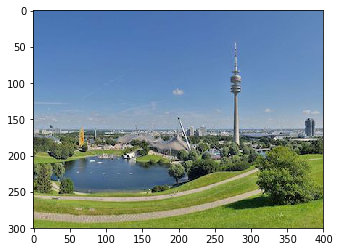

In [23]:
# Load the content image
content_image = scipy.misc.imread("images/olympiapark.jpg")
imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

/Users/ayim/Desktop/virenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


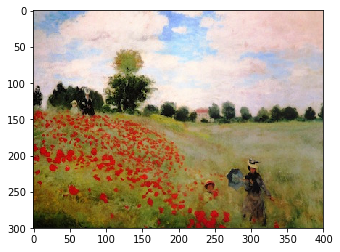

In [3]:
# Load the style image
style_image = scipy.misc.imread("./images/monet.jpg")
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. (Feel free to look in `nst_utils.py` to see the details of `generate_noise_image(...)`; to do so, click "File-->Open..." at the upper-left corner of this Jupyter notebook.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


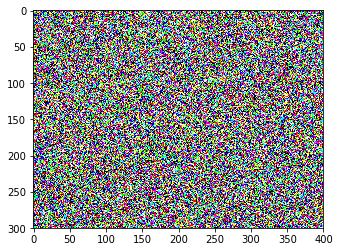

In [4]:
from nst_utils import *
generated_image = generate_noise_image(style_image)
imshow(generated_image[0])

In [71]:
# Load the model
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [72]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [73]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [75]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step
train_step = optimizer.minimize(J)

In [76]:
def model_nn(sess, input_image, num_iterations = 140):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model["input"])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/gen2.jpg', generated_image)
    
    return generated_image

Finally trained the NST

In [77]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5.14649e+09
content cost = 6540.85
style cost = 1.28661e+08
Iteration 20 :
total cost = 9.72477e+08
content cost = 12398.7
style cost = 2.43088e+07
Iteration 40 :
total cost = 4.94236e+08
content cost = 13695.8
style cost = 1.23525e+07
Iteration 60 :
total cost = 3.29712e+08
content cost = 14236.2
style cost = 8.23924e+06
Iteration 80 :
total cost = 2.50741e+08
content cost = 14558.8
style cost = 6.26488e+06
Iteration 100 :
total cost = 2.02078e+08
content cost = 14810.7
style cost = 5.04825e+06
Iteration 120 :
total cost = 1.67914e+08
content cost = 15041.5
style cost = 4.19409e+06


array([[[[ -51.78285217,   -2.47615695,   20.40782356],
         [ -87.35849762,   54.94168472,   68.73626709],
         [   1.45278907,   34.74964905,   82.15462494],
         ..., 
         [ -19.7180481 ,   49.97750092,   75.45352936],
         [ -17.4418354 ,   41.65339661,   87.60574341],
         [ -41.19634247,   14.12351036,  102.08655548]],

        [[ -44.60194397,   41.36545944,  167.26202393],
         [  12.37211514,   47.13181686,  101.19979095],
         [  13.0905695 ,   40.00833511,   85.94472504],
         ..., 
         [ -69.05221558,   21.25959587,   85.40023804],
         [ -46.67692947,   -5.37439775,   69.66662598],
         [ -77.2312088 ,  -35.24882889,   77.48588562]],

        [[ -20.27810669,   37.92116928,   92.74169922],
         [ -19.73177147,   38.22919083,   90.1051178 ],
         [ -28.97183037,   24.41939354,   80.20132446],
         ..., 
         [ -29.19279861,   -1.97815597,   70.96141052],
         [ -28.73352623,   -4.6117239 ,   47.87176895],

## Result

/Users/ayim/Desktop/virenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


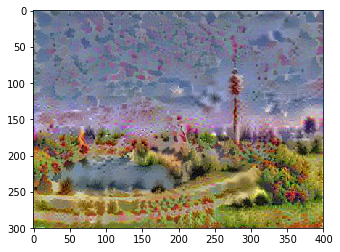

In [5]:
result_image = scipy.misc.imread("./output/gen2.jpg")
imshow(result_image)